In [45]:
def get(phix,m):     # Returns phi only upto the no. of features 0 to m-1
    newphi = np.copy(phix.T)
    newphi = newphi[0:m]
    return newphi.T

def plot_all(x,hs,xl = 'X',yl = 'Y',legends = [''],xlog = False,scatterFirst = False, ylog = False):      # Plots all curves with x on X and all elements oh hs on Y, ll = xlabel, yl = ylabel, xlog = if x is on logarithmic scale, legends = legends
    plt.figure()
    plt.xlabel(xl)
    plt.ylabel(yl)
    if(xlog):
        plt.xscale('log')
    if(ylog):
        plt.yscale('log')
    if(scatterFirst):
        plt.scatter(x,hs[0],color = 'indigo')
    for h in hs[scatterFirst:]:
        plt.plot(x,h)
    plt.legend(legends)
    plt.show()

def make_batches(phix,tx,bs):                 # Returns the batches of phi,t with batch_size = bs
    N = phix.shape[0]
    newphi = np.copy(phix)
    newphi = np.concatenate((newphi,np.array([tx]).T),axis = 1)
    np.random.shuffle(newphi)
    sz = math.floor(N/bs)
    # print(sz,bs)
    newphi = newphi[0:sz*bs]
    N = phix.shape[0]
    newphi = np.array(np.split(newphi,sz))
    phis = []
    ts = []
    for ph in newphi:
        ts.append(ph.T[-1])
        phis.append((ph.T[0:-1]).T)
    return phis,ts

def MPPI(phi, t, m, lamda):
    phix = get(phi,m)
    wm = (( np.linalg.inv(lamda*np.eye(m) + (phix.T).dot(phix)).dot(phix.T)).dot(t))
    h = phix.dot(wm)
    return wm,h

def SSE(hi,ti):   # Returns Sum of Squares error between the hypothesis h and the target t
    N = hi.shape[0]
    cost = (1/N)*0.5*sum(np.square(hi-ti))
    return cost

def SSG(phii,ti,h,lamda,w):
    N = ti.shape[0]
    gd = np.dot(phii.T,h-ti)/N + lamda*w
    return gd

def batch_gd(phi, alpha, tx, iters, batch_size, m,lamda =0, errorf = SSE, gradient= SSG):
    phix = get(phi,m)
    w = np.ones(m,dtype = 'float')
    M = phix.shape[1]       # Number of features
    N = batch_size          # Number of data points
    for i in range(iters):
        phis,ts = make_batches(phix,tx,batch_size)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                for i in range(len(phis)):
                    phii = phis[i]
                    ti = ts[i]
                    h = phii.dot(w)

                    gd = gradient(phii,ti,h,lamda,w)

                    w = w - (alpha * gd)

                    h = phii.dot(w)
            except RuntimeWarning as e:
                return e
    h = phix.dot(w)
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            cost = errorf(h,tx)
        except RuntimeWarning as e:
            return e
    return w,cost,h

def check(phi,t,m):
    N = phi.shape[0]
    batch_sizes =[]
    alphas = []
    for bs in [1,2,5,10,20,50,100]:
        batch_sizes.append(bs)
        alpha,cost = find_alpha(phi,t,bs,1e-5,1,m)
        alphas.append(alpha,cost)
        print(bs,alphas[-1])
    plt.plot(batch_sizes,alphas)

def find_alpha(phi,t,batch_size,l,r,lamda,m,errorf):
    mid = 0
    cost = 0
    for _ in range(5):
        mid = (l+r)/2
        output = batch_gd(phi,mid,t,10000,batch_size,lamda = lamda,m = m)
        if(isinstance(output,RuntimeWarning)):
            r = mid
        elif(output[1] > 1e6):
            r = mid
        else:
            cost = output[1]
            l =mid
    return l,cost

def Cross_Validation(phi,tx,alpha,parts,lamda,m,batch_size = 1,iters=5000,errorf=SSE,gradient=SSG,pinv = True):   # Finds cross validation Error for the given arguments
    # print(m,lamda)
    phix = get(phi,m)
    N = phix.shape[0]
    bs = math.floor(N/parts)
    alls = np.array_split(range(N),parts)
    test_error = 0.0
    training_error = 0.0
    for i in range(parts):
        phii = np.delete(phix,alls[i],axis = 0)
        ti = np.delete(tx,alls[i])
        if(pinv):
            wi,hi = MPPI(phii,ti,m,lamda)   
            costi = SSE(hi,ti)      # Represents the training error
        else:
            wi,costi,hi = batch_gd(phi = phii, alpha = alpha,tx = ti,batch_size= batch_size,lamda = lamda, iters = iters,m = m)
        # Wi and Hi are weights and hypothesis values at all inputs in this training set
        hypothesis_i = phix[alls[i]].dot(wi)    # Represents the hypothesis values at the test set
        training_error += costi # Increment total training error
        test_error += SSE(hypothesis_i,tx[alls[i]]) # Increment total testing error
    test_error /= parts
    training_error /= parts
    test_error = math.sqrt(test_error)
    training_error = math.sqrt(training_error)
    print(test_error,training_error)
    return test_error,training_error

In [77]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
M = 100 # Order of poly is M-1
from random import randint as rand
with open("gaussian.csv", 'r') as f:
    data = list(csv.reader(f,delimiter = ','))
# data= data[0:20]
data = np.array(data)
data = np.array([[float(d[0]),float(d[1])] for d in data])
data = data[np.argsort(data[:,0])]
x = np.array([d[0] for d in data], dtype = 'float')
t = np.array([d[1] for d in data], dtype= 'float')
phi = np.array([[pow(xv,i) for i in range(M)] for xv in x])
N = t.size




In [88]:
errors = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, pinv = False) for i in range(2,25)]

0.00011536467128984184 7.860164292204728e-05
0.0011217757939991388 0.00017584155161623081
0.0016676018714772485 0.000526492363984865
0.0019615158605358627 0.000609606015088311
0.002118637777404235 0.00047063053418884603
0.002178408299304699 0.0003170190431614475
0.0020710951101167727 0.00021864972918792677
0.001756172987679372 0.00017377684976584056
0.0013409140594449354 0.00018228932447758703
0.0009978078356117008 0.00023032583105424463
0.0009365411422749787 0.0002882613999753426
0.0013582993413671287 0.00032671294698791647
0.0024245407852351137 0.0003299180714012957
0.004235845321972727 0.0003016794663844897
0.006735614873189542 0.00025822816880997554
0.009623331887717421 0.00021816626049767006
0.012344912147092383 0.00019152920339527866
0.014051807752873138 0.00018027537117403425
0.013868975708483892 0.00018425223952352098
0.011182974761066907 0.00019963940288471056
0.006251284401497583 0.00022391373946373613
0.0017130066508954083 0.0002475208625154702
0.004497567133496374 0.0002714

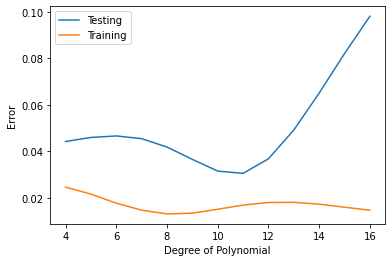

In [89]:
test,train = np.array(errors).T
test = np.sqrt(test)
train = np.sqrt(train)
test = test[3:16]
train = train[3:16]
plot_all(x = range(4,len(test)+4), hs = [test,train],  legends = ['Testing','Training'], xl ='Degree of Polynomial', yl ='Error',)

In [ ]:
errors = [Cross_Validation(phi,t,alpha = 1e-4, batch_size = 1,parts = 4, lamda = 0, m = i) for i in range(1,10)]

In [41]:
arr = [pow(10,i) for i in range(-15,-3,2)]
errors = [Cross_Validation(phi,t,alpha = 0.5, batch_size = 5,parts = 4, lamda = i, m = 6, pinv =False) for i in arr]

0.009517791571575299 1.6556124916071426e-05
0.009439345292075381 4.368340094350756e-05
0.009462513776902583 1.5635128621056604e-05
0.009405787712026234 1.6838515028989438e-05
0.009602462621265854 0.00015927208332300221
0.0076040005286233375 2.5980992975006763e-05


In [73]:
phi.shape

(20, 100)